In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import warnings
import time
warnings.filterwarnings("ignore")

import pathlib

In [27]:
def datCnv(src):
    return pd.to_datetime(src)

def IOBP2_cleaning(filepath,clean_data_path):
    #load patient roster
    filename = filepath + 'IOBP2PtRoster.txt'
    roster = pd.read_csv(filename, sep="|")
    #build clean roster
    PatientInfo = pd.DataFrame(columns=['PtID','StartDate','EndDate','TrtGroup','Age'])
    PatientInfo['PtID'] = roster['PtID']
    PatientInfo['StartDate'] = roster['RandDt']
    PatientInfo['EndDate'] = roster['TransRandDt']
    PatientInfo['TrtGroup'] = roster['TrtGroup']
    PatientInfo['Age'] = roster['AgeAsofEnrollDt']
    
    #load manual injections data
    filename = filepath + 'IOBP2ManualInsulinInj.txt'
    data_man_inj = pd.read_csv(filename, sep="|")
    #create datetime objects for easy inclusion
    data_man_inj['DateTime'] = np.nan
    data_man_inj.InsInjDt = [datetime.strptime(data_man_inj['InsInjDt'][x],'%m/%d/%Y').date() for x in data_man_inj.index.values]
    for i in data_man_inj.index.values:
        if (data_man_inj.InsInjAMPM[i] == 'PM') & (data_man_inj.InsInjHr[i]!= 12):
            data_man_inj.InsInjHr[i] = data_man_inj.InsInjHr[i] + 12

        data_man_inj['DateTime'][i] = datetime(data_man_inj.InsInjDt[i].year,
                                           data_man_inj.InsInjDt[i].month,
                                           data_man_inj.InsInjDt[i].day,
                                           data_man_inj.InsInjHr[i],
                                           data_man_inj.InsInjMin[i],
                                          )
    #load insulin pump data
    filename = filepath + 'IOBP2DeviceiLet.txt'
    data = pd.read_csv(filename, sep="|")
    #create new dateframe for clean data
    cleaned_data = pd.DataFrame()
    patient_data = pd.DataFrame()
    for id in PatientInfo.PtID.values:
        subj_data = data[data.PtID == id].reset_index(drop=True)
        

        subj_info = PatientInfo[PatientInfo.PtID == id].reset_index(drop=True)
        if len(subj_data) > 0:
            subj_info['DaysOfData'] = np.nan
            subj_info['Weight'] = np.nan
            subj_info['AVG_CGM'] = np.nan
            subj_info['STD_CGM'] = np.nan
            subj_info['CGM_Availability'] = np.nan
            subj_info['eA1C'] = np.nan
            subj_info['TIR'] = np.nan
            subj_info['TDD'] = np.nan

            subj_inj = data_man_inj[data_man_inj.PtID == id].reset_index(drop=True)

            data_preclean = subj_data.filter(items=['DeviceDtTm','PtID','CGMVal','BGMVal','InsDelivAvail','InsDelivPrev'])
            data_preclean['InsulinDelivered'] = data_preclean.InsDelivPrev.shift(-1)
            data_preclean['DateTime'] = data_preclean.DeviceDtTm.apply(datCnv)

#             if id in [222,463,112]: #each day at midnight the datetime stamp is only a date
#                 for x in data_preclean.index:
#                     try:
#                         data_preclean['DeviceDtTm'][x] = datetime.strptime(data_preclean['DeviceDtTm'][x],'%m/%d/%Y %H:%M:%S %p').isoformat()
#                     except:
#                         data_preclean['DeviceDtTm'][x] = datetime.strptime(data_preclean['DeviceDtTm'][x],'%m/%d/%Y').isoformat()        
#             else:
#                 data_preclean['DeviceDtTm'] = [datetime.strptime(data_preclean['DeviceDtTm'][x],'%m/%d/%Y %H:%M:%S %p').isoformat() for x in data_preclean.index]
#             data_preclean['DateTime'] = [datetime.fromisoformat(data_preclean['DeviceDtTm'][x]) for x in data_preclean.index]
            data_preclean = data_preclean.sort_values(by='DateTime').reset_index(drop=True)
            try:
                subj_info['StartDate'] = subj_info.StartDate[0].apply(datCnv)
                data_preclean = data_preclean[data_preclean.DateTime >= subj_info.StartDate.iloc[0]]
                
            except:
                pass
            #not everyone has an end data
            try:
                subj_info['EndDate'] = subj_info.EndDate[0].apply(datCnv)
                data_preclean = data_preclean[data_preclean.DateTime <= subj_info.EndDate.iloc[0]]
            except:
                pass

            data_preclean['TimeBetween'] = data_preclean.DateTime.diff()
            data_preclean['TimeBetween'] = [data_preclean['TimeBetween'][x].total_seconds()/60 for x in data_preclean.index]
            #add manual injections
            data_preclean['ManualIns'] = 0
            if len(subj_inj)>0:
                #find closest CGM time to injection
                for i in subj_inj.index.values:
                    data_preclean['TimeFromInj'] = [(data_preclean['DateTime'][x] - subj_inj.DateTime[i]).total_seconds() for x in data_preclean.index]
                    data_preclean['TimeFromInj'] = data_preclean['TimeFromInj'].abs()
                    injection_index = data_preclean[data_preclean.TimeFromInj == data_preclean.TimeFromInj.min()].index.values[0]
                    data_preclean['ManualIns'][injection_index] = subj_inj.InsInjAmt[i]

            clean_subj = data_preclean.filter(items=['DateTime','PtID','CGMVal','BGMVal','InsDelivAvail','InsulinDelivered','ManualIns'])
            clean_subj['DateTime'] = [clean_subj['DateTime'][x].isoformat() for x in clean_subj.index]
            clean_subj = clean_subj.rename(columns={"DeviceDtTm": "LocalTime", 
                                       "InsDelivAvail": "InsulinAvailable",
                                       "ManualIns": "ManualDelivery"
                                      })

            cleaned_data = pd.concat([cleaned_data,clean_subj])
            if len(clean_subj)>0:
                subj_info['DaysOfData'][0] = np.round(len(subj_data)/288,2)
                subj_info['Weight'][0] = subj_data.PtWeight.iloc[-1]
                subj_info['AVG_CGM'][0] = np.round(clean_subj.CGMVal.mean(),2)
                subj_info['STD_CGM'][0] = np.round(clean_subj.CGMVal.std(),2)
                subj_info['CGM_Availability'][0] = np.round(100 * len(clean_subj[clean_subj.CGMVal>0])/len(clean_subj),2)
                subj_info['eA1C'][0] = np.round((46.7 + clean_subj.CGMVal.mean())/28.7,2)
                subj_info['TIR'][0] = np.round(100 * len(clean_subj[(clean_subj.CGMVal>=70) & (clean_subj.CGMVal<=180)])/len(clean_subj[clean_subj.CGMVal>0]),2)
                subj_info['TDD'][0] = np.round(clean_subj.InsulinDelivered.sum()/subj_info['DaysOfData'][0],2)

                pt_data = subj_info.filter(items=['PtID','StartDate','EndDate','TrtGroup','Age','DaysOfData','Weight','AVG_CGM','STD_CGM','CGM_Availability',
                                                  'eA1C','TIR','TDD'])
                patient_data = pd.concat([patient_data,pt_data])
        #creates a new folder (if it doesnt exist) for cleaned data to be saved
        pathlib.Path(clean_data_path + "CleanedData").mkdir(parents=True, exist_ok=True)
        cleaned_data.to_csv(clean_data_path + "CleanedData/IOBP2_cleaned_egvinsulin.csv",index=False)
        patient_data.to_csv(clean_data_path + "CleanedData/IOBP2_patient_data.csv",index=False)
    
    return cleaned_data,patient_data

In [13]:
cleaned_data_path = '/Users/rachelbrandt/egvinsulin/' #location where you want cleaned data to be stored
pathname = '/Users/rachelbrandt/Downloads/IOBP2 RCT Public Dataset/Data Tables/' #location of data to be cleaned

cleaned_data,patient_data = IOBP2_cleaning(pathname,cleaned_data_path)
cleaned_data

,DateTime,PtID,CGMVal,BGMVal,InsulinAvailable,InsulinDelivered,ManualDelivery
0,2020-07-26T00:02:43,235,204.0,NaN,True,0.160,0
1,2020-07-26T00:07:43,235,206.0,NaN,True,0.069,0
2,2020-07-26T00:12:43,235,204.0,NaN,True,0.000,0
3,2020-07-26T00:17:43,235,200.0,NaN,True,0.076,0
4,2020-07-26T00:22:43,235,199.0,NaN,True,0.000,0
...,...,...,...,...,...,...,...
28195,2021-04-19T11:02:02,346,NaN,NaN,False,0.000,0
28196,2021-04-19T11:07:02,346,NaN,NaN,False,0.000,0
28197,2021-04-19T11:12:02,346,NaN,NaN,False,0.000,0
28198,2021-04-19T11:17:02,346,NaN,NaN,False,0.000,0


In [38]:
# def datCnv(src):
#     return pd.to_datetime(src)

# def DCLP5_cleaning(filepath_old_data,filepath_new_data,clean_data_path):
    
#     filename = filepath_new_data + 'DCLP5TandemBolus_Completed_Combined_b.txt'
#     bolus_data = pd.read_csv(filename, sep="|",low_memory = False)

#     filename = filepath_old_data + 'DexcomClarityCGM.csv'
#     data_cgm = pd.read_csv(filename, sep="|",low_memory = False)

#     filename = filepath_old_data + 'TandemAACGMDATA.csv'
#     data_deliv = pd.read_csv(filename, sep="|",low_memory = False)

#     filename = filepath_new_data + 'PtRoster.txt'
#     roster = pd.read_csv(filename, sep="|")
# #     if study == 'DCLP3':
# #         filename = filepath_new_data + 'DCLP5TandemBolus_Completed_Combined_b.txt'
# #         bolus_data = pd.read_csv(filename, sep="|",low_memory = False)
        
# #         filename = filepath_old_data + 'DexcomClarityCGM_a.txt'
# #         data_cgm = pd.read_csv(filename, sep="|",low_memory = False)

# #         filename = filepath_old_data + 'TandemAACGMDATA.csv'
# #         data_deliv = pd.read_csv(filename, sep="|",low_memory = False)

# #         filename = filepath_new_data + 'PtRoster.txt'
# #         roster = pd.read_csv(filename, sep="|")
    
#     PatientInfo = pd.DataFrame(columns=['PtID','StartDate','Phase2Start','TrtGroup','Age'])
#     PatientInfo['PtID'] = roster['PtID']
#     PatientInfo['StartDate'] = roster['RandDt']
#     PatientInfo['Phase2Start'] = roster['Phase2StartDt']
#     PatientInfo['TrtGroup'] = roster['trtGroup']
#     PatientInfo['Age'] = roster['AgeAtEnrollment']
    
    
        
#     cleaned_data = pd.DataFrame()
#     patient_data = pd.DataFrame()
#     for id in PatientInfo.PtID.values:
#         try:
#             subj_info = PatientInfo[PatientInfo.PtID == id].reset_index(drop=True)
#             patient_cgm = data_cgm[data_cgm.PtID == id].filter(items=['PtID','DataDtTm','CGM'])
#             patient_deliv = data_deliv[data_deliv.PtID == id].filter(items=['DataDtTm','dU','Usugg'])
#             patient_bolus = bolus_data[bolus_data.PtID == id].filter(items=['DataDtTm','BolusAmount','BolusType'])

#             patient_deliv['DateTime'] = patient_deliv.DataDtTm.apply(datCnv)
#             patient_cgm['DateTime'] = patient_cgm.DataDtTm.apply(datCnv)
#             patient_bolus['DateTime'] = patient_bolus.DataDtTm.apply(datCnv)
            
#             patient_deliv = patient_deliv.sort_values(by='DateTime').reset_index(drop=True)
#             patient_cgm = patient_cgm.sort_values(by='DateTime').reset_index(drop=True)
#             patient_bolus = patient_bolus.sort_values(by='DateTime').reset_index(drop=True)
            
#             patient_cgm = patient_cgm[patient_cgm.DateTime >= subj_info.StartDate.iloc[0]]
#             patient_bolus = patient_bolus[patient_bolus.DateTime >= subj_info.StartDate.iloc[0]]
#             patient_deliv = patient_deliv[patient_deliv.DateTime >= subj_info.StartDate.iloc[0]]

#             #round all time to nearest 5 minute value
#             patient_cgm['DateTime'] = patient_cgm['DateTime'].dt.round("5min")
#             patient_deliv['DateTime'] = patient_deliv['DateTime'].dt.round("5min")
#             patient_bolus['DateTime'] = patient_bolus['DateTime'].dt.round("5min")
#             #merge dataframes on rounded time - will keep true pump time
#             data_merge = patient_deliv.merge(patient_cgm,on='DateTime',how='outer').merge(patient_bolus,on='DateTime',how='outer')
#             #keep data for only when the pump was operational (has a time value) - some CGM data predates insulin
#             data_merge_final = data_merge[(data_merge.DataDtTm_x.notna())]
#             #convert extended boluses to 50% at time of bolus (t) and 50% extended for 2 hours (from t+1 to t+24)
#             extended_index = data_merge_final[data_merge_final.BolusType=='Extended'].index.values
#             data_merge_final.BolusAmount = data_merge_final.BolusAmount.fillna(0)
#             for e in extended_index:
#                 data_merge_final.BolusAmount[e] = data_merge_final.BolusAmount[e]*0.5
#                 data_merge_final.BolusAmount.loc[e+1:e+24] = data_merge_final.BolusAmount.loc[e+1:e+24] + (data_merge_final.BolusAmount[e]*0.5)/24
#             data_merge_final['BasalDelivery'] = data_merge_final.Usugg/1000
#             data_merge_final['InsulinDelivered'] = data_merge_final.BasalDelivery + data_merge_final.BolusAmount
#             clean_subj = data_merge_final.filter(items=['PtID','DataDtTm_x','CGM','BasalDelivery','BolusAmount','BolusType','InsulinDelivered'])
#             clean_subj['PtID'] = id
#             clean_subj = clean_subj.rename(columns={"DataDtTm_x": "DateTime", 
#                                            "BolusAmount": "BolusDelivery",
#                                            "CGM": "CGMVal"         
#                                           })

#             cleaned_data = pd.concat([cleaned_data,clean_subj])
#             if len(clean_subj)>0:
#                 subj_info = PatientInfo[PatientInfo.PtID == id].reset_index(drop=True)
#                 subj_info['DaysOfData'] = np.nan
#                 subj_info['AVG_CGM'] = np.nan
#                 subj_info['STD_CGM'] = np.nan
#                 subj_info['CGM_Availability'] = np.nan
#                 subj_info['eA1C'] = np.nan
#                 subj_info['TIR'] = np.nan
#                 subj_info['TDD'] = np.nan

#                 subj_info['DaysOfData'][0] = np.round(len(data_merge_final)/288,2)
#                 subj_info['AVG_CGM'][0] = np.round(clean_subj.CGMVal.mean(),2)
#                 subj_info['STD_CGM'][0] = np.round(clean_subj.CGMVal.std(),2)
#                 subj_info['CGM_Availability'][0] = np.round(100 * len(clean_subj[clean_subj.CGMVal>0])/len(clean_subj),2)
#                 subj_info['eA1C'][0] = np.round((46.7 + clean_subj.CGMVal.mean())/28.7,2)
#                 subj_info['TIR'][0] = np.round(100 * len(clean_subj[(clean_subj.CGMVal>=70) & (clean_subj.CGMVal<=180)])/len(clean_subj[clean_subj.CGMVal>0]),2)
#                 subj_info['TDD'][0] = np.round(clean_subj.InsulinDelivered.sum()/subj_info['DaysOfData'][0],2)

#                 pt_data = subj_info.filter(items=['PtID','StartDate','Phase2Start','TrtGroup','Age','DaysOfData','Weight','AVG_CGM','STD_CGM','CGM_Availability',
#                                                   'eA1C','TIR','TDD'])
#                 patient_data = pd.concat([patient_data,pt_data])
#         except:
#             pass
#     pathlib.Path(clean_data_path + "CleanedData").mkdir(parents=True, exist_ok=True)
#     cleaned_data.to_csv(clean_data_path + "CleanedData/DCLP5_cleaned_egvinsulin.csv",index=False)
#     patient_data.to_csv(clean_data_path + "CleanedData/DCLP5_patient_data.csv",index=False)
    
#     return cleaned_data,patient_data

In [ ]:
# filepath_old_data = '/Users/rachelbrandt/Downloads/Data Files DCLP5/'
# filepath_new_data = '/Users/rachelbrandt/Downloads/DCLP5_Dataset_2022-01-20-5e0f3b16-c890-4ace-9e3b-531f3687cf53/'
# cleaned_data_path = '/Users/rachelbrandt/egvinsulin/' #location where you want cleaned data to be stored

# cleaned_data,patient_data =  DCLP_cleaning(filepath_old_data,filepath_new_data,cleaned_data_path)
# patient_data

In [14]:
def datCnv(src):
    return pd.to_datetime(src)

def DCLP3_cleaning(filepath_data,clean_data_path):
    filename = filepath_data + 'Pump_BasalRateChange.txt'
    BasalRate = pd.read_csv(filename, sep="|", low_memory = False)

    filename = filepath_data + 'Pump_BolusDelivered.txt'
    Bolus = pd.read_csv(filename, sep="|" , low_memory = False)

    filename = filepath_data + 'Pump_CGMGlucoseValue.txt'
    CGM = pd.read_csv(filename, sep="|", low_memory = False)

    filename = filepath_data + 'PtRoster_a.csv'
    roster = pd.read_csv(filename, low_memory = False)
    
    PatientInfo = pd.DataFrame(columns=['PtID','StartDate','TrtGroup'])
    PatientInfo['PtID'] = roster['PtID']
    PatientInfo['StartDate'] = roster['RandDt']
    PatientInfo['TrtGroup'] = roster['trtGroup']
    
    cleaned_data = pd.DataFrame()
    patient_data = pd.DataFrame()
    j = 0
    for id in PatientInfo.PtID.values:
        print(id)
        try:
            subj_info = PatientInfo[PatientInfo.PtID == id].reset_index(drop=True)
            patient_deliv = BasalRate[BasalRate.PtID == id]
            patient_cgm = CGM[CGM.PtID == id]
            patient_bolus = Bolus[Bolus.PtID == id]

            patient_deliv['DateTime'] = patient_deliv.DataDtTm.apply(datCnv)
            patient_cgm['DateTime'] = patient_cgm.DataDtTm.apply(datCnv)
            patient_bolus['DateTime'] = patient_bolus.DataDtTm.apply(datCnv)
            
            patient_deliv = patient_deliv.sort_values(by='DateTime').reset_index(drop=True)
            patient_cgm = patient_cgm.sort_values(by='DateTime').reset_index(drop=True)
            patient_bolus = patient_bolus.sort_values(by='DateTime').reset_index(drop=True)
            
            patient_cgm['DateTime'] = patient_cgm['DateTime'].dt.round("5min")
            patient_deliv['DateTime'] = patient_deliv['DateTime'].dt.round("5min")
            patient_bolus['DateTime'] = patient_bolus['DateTime'].dt.round("5min")
            
            patient_cgm['UnixTime'] = [int(time.mktime(patient_cgm.DateTime[x].timetuple())) for x in patient_cgm.index]
            patient_deliv['UnixTime'] = [int(time.mktime(patient_deliv.DateTime[x].timetuple())) for x in patient_deliv.index]
            patient_bolus['UnixTime'] = [int(time.mktime(patient_bolus.DateTime[x].timetuple())) for x in patient_bolus.index]
            
            start_date = patient_deliv.DateTime.iloc[0].date()
            end_date = patient_deliv.DateTime.iloc[-1].date() + timedelta(days=1)
            
            data_new_time = pd.DataFrame(columns=['DateTime_keep'])
            data_new_time['DateTime_keep'] = pd.date_range(start = start_date, end = end_date, freq="5min").values
            data_new_time['UnixTime'] = [int(time.mktime(data_new_time.DateTime_keep[x].timetuple())) for x in data_new_time.index]
            data_new_time = data_new_time.drop_duplicates(subset=['UnixTime']).sort_values(by='UnixTime')
            
            #remove duplicate basal rates
            dups = patient_deliv[patient_deliv.duplicated(subset='UnixTime', keep=False)]
            utime = dups.UnixTime.unique()
            count = 0
            replace_data = pd.DataFrame(index=range(len(utime)),columns=dups.columns)
            for u in utime:
                dup_data = dups[dups.UnixTime==u]
                replace_data['DateTime'][count] = dup_data['DateTime'].iloc[0]
                replace_data['UnixTime'][count] = u
                replace_data['CommandedBasalRate'][count] = dup_data['CommandedBasalRate'].iloc[-1]
                count += 1
            
            patient_deliv = patient_deliv.drop_duplicates(subset=['UnixTime'],keep=False)
            patient_deliv.CommandedBasalRate = patient_deliv.CommandedBasalRate/12
            patient_deliv_dup_rem = pd.concat([patient_deliv,replace_data]).sort_values(by='UnixTime').reset_index(drop=True)
            patient_deliv_dup_rem.UnixTime = patient_deliv_dup_rem.UnixTime.astype(int)
            
            insulin_merged = pd.merge_asof(data_new_time, patient_deliv, on="UnixTime",direction="nearest",tolerance=149)
            insulin_merged.CommandedBasalRate = insulin_merged.CommandedBasalRate.ffill()
            
            dups = patient_bolus[patient_bolus.duplicated(subset='UnixTime', keep=False)]
            utime = dups.UnixTime.unique()
            count = 0
            replace_data = pd.DataFrame(index=range(len(utime)),columns=dups.columns)
            for u in utime:
                dup_data = dups[dups.UnixTime==u]
                replace_data['DateTime'][count] = dup_data['DateTime'].iloc[0]
                replace_data['UnixTime'][count] = u
                replace_data['BolusAmount'][count] = dup_data['BolusAmount'].sum()
                count += 1
            
            patient_bolus = patient_bolus.drop_duplicates(subset=['UnixTime'],keep=False)
            patient_bolus_dup_rem = pd.concat([patient_bolus,replace_data]).sort_values(by='UnixTime').reset_index(drop=True)
            patient_bolus_dup_rem.UnixTime = patient_bolus_dup_rem.UnixTime.astype(int)
            
            delivery_merged = pd.merge_asof(insulin_merged, patient_bolus_dup_rem, on="UnixTime",direction="nearest",tolerance=149)
            delivery_merged = delivery_merged.filter(items=['DateTime_keep','UnixTime','BolusAmount','CommandedBasalRate','BolusType'])
            
            patient_cgm = patient_cgm.sort_values(by='UnixTime').reset_index(drop=True)
            data_merged = pd.merge_asof(delivery_merged, patient_cgm, on="UnixTime",direction="nearest",tolerance=149)
            data_merged = data_merged.filter(items=['DateTime_keep','UnixTime','BolusAmount','CommandedBasalRate','BolusType','CGMValue'])
            
            extended_index = data_merged[data_merged.BolusType=='Extended'].index.values
            for e in extended_index:
                data_merged.BolusAmount[e] = data_merged.BolusAmount[e]*0.5
                data_merged.BolusAmount.loc[e+1:e+24] = data_merged.BolusAmount.loc[e+1:e+24] + (data_merged.BolusAmount[e]*0.5)/24
            
            data_merged = data_merged.rename(columns={
                                            "CGMValue": "CGMVal",
                                            "BolusAmount": "BolusDelivery",
                                            "CommandedBasalRate": "BasalDelivery",
                                            "DateTime_keep": "DateTime",
                                          }) 
            data_merged['InsulinDelivered'] = data_merged.BasalDelivery + data_merged.BolusDelivery
            data_merged['PtID'] = id
            data_merged = data_merged.filter(items=['PtID','DateTime','BasalDelivery','BolusDelivery','CGMVal','InsulinDelivered','BolusType'])

            cleaned_data = pd.concat([cleaned_data,data_merged])
            if len(data_merged)>0:
                subj_info['DaysOfData'] = np.nan
                subj_info['AVG_CGM'] = np.nan
                subj_info['STD_CGM'] = np.nan
                subj_info['CGM_Availability'] = np.nan
                subj_info['eA1C'] = np.nan
                subj_info['TIR'] = np.nan
                subj_info['TDD'] = np.nan

                subj_info['DaysOfData'][0] = np.round(len(data_merged)/288,2)
                subj_info['AVG_CGM'][0] = np.round(data_merged.CGMVal.mean(),2)
                subj_info['STD_CGM'][0] = np.round(data_merged.CGMVal.std(),2)
                subj_info['CGM_Availability'][0] = np.round(100 * len(data_merged[data_merged.CGMVal>0])/len(data_merged),2)
                subj_info['eA1C'][0] = np.round((46.7 + data_merged.CGMVal.mean())/28.7,2)
                subj_info['TIR'][0] = np.round(100 * len(data_merged[(data_merged.CGMVal>=70) & (data_merged.CGMVal<=180)])/len(data_merged[data_merged.CGMVal>0]),2)
                subj_info['TDD'][0] = np.round(data_merged.InsulinDelivered.sum()/subj_info['DaysOfData'][0],2)

                pt_data = subj_info.filter(items=['PtID','StartDate','TrtGroup','DaysOfData','AVG_CGM','STD_CGM','CGM_Availability',
                                                  'eA1C','TIR','TDD'])
                patient_data = pd.concat([patient_data,pt_data])
        except:
            pass
    pathlib.Path(clean_data_path + "CleanedData").mkdir(parents=True, exist_ok=True)
    cleaned_data.to_csv(clean_data_path + "CleanedData/DCLP3_cleaned_egvinsulin.csv",index=False)
    patient_data.to_csv(clean_data_path + "CleanedData/DCLP3_patient_data.csv",index=False)
    
    return cleaned_data,patient_data

In [ ]:
filepath = '/Users/rachelbrandt/Downloads/DCLP3 Public Dataset - Release 3 - 2022-08-04/Data Files/'
cleaned_data_path = '/Users/rachelbrandt/egvinsulin/' #location where you want cleaned data to be stored

cleaned_data,patient_data =  DCLP3_cleaning(filepath,cleaned_data_path)
patient_data

In [23]:
cleaned_data

,PtID,CommandedBasalRate,DateTime,BasalDelivery,CGMVal,BolusType,BolusDelivery,InsulinDelivered
0,10.0,2.000,2018-04-04 12:55:00,0.166667,NaN,NaN,0.0,0.166667
1,10.0,0.000,2018-04-04 13:00:00,0.000000,NaN,NaN,0.0,0.000000
2,10.0,0.000,2018-04-04 13:05:00,0.000000,NaN,NaN,0.0,0.000000
3,10.0,0.000,2018-04-04 13:10:00,0.000000,NaN,Standard,0.1,0.100000
4,10.0,0.000,2018-04-04 13:15:00,0.000000,NaN,NaN,0.0,0.000000
...,...,...,...,...,...,...,...,...
54025,171.0,0.950,2018-10-24 08:45:00,0.079167,168.0,NaN,0.0,0.079167
54026,171.0,0.950,2018-10-24 08:50:00,0.079167,174.0,NaN,0.0,0.079167
54027,171.0,1.119,2018-10-24 08:55:00,0.093250,192.0,NaN,0.0,0.093250
54028,171.0,3.207,2018-10-24 09:00:00,0.267250,189.0,NaN,0.0,0.267250


In [52]:
def datCnv(src):
    return pd.to_datetime(src)

def DCLP5_cleaning(filepath_data,clean_data_path,data_val = True):
    filename = filepath_data + 'DCLP5TandemBolus_Completed_Combined_b.txt'
    Bolus = pd.read_csv(filename, sep="|", low_memory = False)

    filename = filepath_data + 'DCLP5TandemBASALRATECHG_b.txt'
    BasalRate = pd.read_csv(filename, sep="|" , low_memory = False)

    filename = filepath_data + 'DexcomClarityCGM.txt'
    CGM = pd.read_csv(filename, sep="|", low_memory = False)

    filename = filepath + 'PtRoster.txt'
    roster = pd.read_csv(filename, sep="|")
    
    PatientInfo = pd.DataFrame(columns=['PtID','StartDate','TrtGroup'])
    PatientInfo['PtID'] = roster['PtID']
    PatientInfo['StartDate'] = roster['RandDt']
    PatientInfo['TrtGroup'] = roster['trtGroup']
    
    cleaned_data = pd.DataFrame()
    patient_data = pd.DataFrame()
    j = 0
    for id in PatientInfo.PtID.values:
        try:
            subj_info = PatientInfo[PatientInfo.PtID == id].reset_index(drop=True)
            patient_deliv = BasalRate[BasalRate.PtID == id]
            patient_cgm = CGM[CGM.PtID == id]
            patient_bolus = Bolus[Bolus.PtID == id]

            patient_deliv['DateTime'] = patient_deliv.DataDtTm.apply(datCnv)
            patient_cgm['DateTime'] = patient_cgm.DataDtTm.apply(datCnv)
            patient_bolus['DateTime'] = patient_bolus.DataDtTm.apply(datCnv)
            
            patient_deliv = patient_deliv.sort_values(by='DateTime').reset_index(drop=True)
            patient_cgm = patient_cgm.sort_values(by='DateTime').reset_index(drop=True)
            patient_bolus = patient_bolus.sort_values(by='DateTime').reset_index(drop=True)
            
            patient_cgm['DateTime'] = patient_cgm['DateTime'].dt.round("5min")
            patient_deliv['DateTime'] = patient_deliv['DateTime'].dt.round("5min")
            patient_bolus['DateTime'] = patient_bolus['DateTime'].dt.round("5min")
            
            patient_cgm['UnixTime'] = [int(time.mktime(patient_cgm.DateTime[x].timetuple())) for x in patient_cgm.index]
            patient_deliv['UnixTime'] = [int(time.mktime(patient_deliv.DateTime[x].timetuple())) for x in patient_deliv.index]
            patient_bolus['UnixTime'] = [int(time.mktime(patient_bolus.DateTime[x].timetuple())) for x in patient_bolus.index]
            
            start_date = patient_deliv.DateTime.iloc[0].date()
            end_date = patient_deliv.DateTime.iloc[-1].date() + timedelta(days=1)
            
            data_new_time = pd.DataFrame(columns=['DateTime_keep'])
            data_new_time['DateTime_keep'] = pd.date_range(start = start_date, end = end_date, freq="5min").values
            data_new_time['UnixTime'] = [int(time.mktime(data_new_time.DateTime_keep[x].timetuple())) for x in data_new_time.index]
            data_new_time = data_new_time.drop_duplicates(subset=['UnixTime']).sort_values(by='UnixTime')
            
            #remove duplicate basal rates
            dups = patient_deliv[patient_deliv.duplicated(subset='UnixTime', keep=False)]
            utime = dups.UnixTime.unique()
            count = 0
            replace_data = pd.DataFrame(index=range(len(utime)),columns=dups.columns)
            for u in utime:
                dup_data = dups[dups.UnixTime==u]
                replace_data['DateTime'][count] = dup_data['DateTime'].iloc[0]
                replace_data['UnixTime'][count] = u
                replace_data['CommandedBasalRate'][count] = dup_data['CommandedBasalRate'].iloc[-1]
                count += 1
            
            patient_deliv = patient_deliv.drop_duplicates(subset=['UnixTime'],keep=False)
            patient_deliv.CommandedBasalRate = patient_deliv.CommandedBasalRate/12
            patient_deliv_dup_rem = pd.concat([patient_deliv,replace_data]).sort_values(by='UnixTime').reset_index(drop=True)
            patient_deliv_dup_rem.UnixTime = patient_deliv_dup_rem.UnixTime.astype(int)
            
            insulin_merged = pd.merge_asof(data_new_time, patient_deliv, on="UnixTime",direction="nearest",tolerance=149)
            insulin_merged.CommandedBasalRate = insulin_merged.CommandedBasalRate.ffill()
            
            dups = patient_bolus[patient_bolus.duplicated(subset='UnixTime', keep=False)]
            utime = dups.UnixTime.unique()
            count = 0
            replace_data = pd.DataFrame(index=range(len(utime)),columns=dups.columns)
            for u in utime:
                dup_data = dups[dups.UnixTime==u]
                replace_data['DateTime'][count] = dup_data['DateTime'].iloc[0]
                replace_data['UnixTime'][count] = u
                replace_data['BolusAmount'][count] = dup_data['BolusAmount'].sum()
                count += 1
            
            patient_bolus = patient_bolus.drop_duplicates(subset=['UnixTime'],keep=False)
            patient_bolus_dup_rem = pd.concat([patient_bolus,replace_data]).sort_values(by='UnixTime').reset_index(drop=True)
            patient_bolus_dup_rem.UnixTime = patient_bolus_dup_rem.UnixTime.astype(int)
            patient_bolus_dup_rem.BolusAmount = patient_bolus_dup_rem.BolusAmount.fillna(0)

            delivery_merged = pd.merge_asof(insulin_merged, patient_bolus_dup_rem, on="UnixTime",direction="nearest",tolerance=149)
            delivery_merged = delivery_merged.filter(items=['DateTime_keep','UnixTime','BolusAmount','CommandedBasalRate','BolusType'])
            
            patient_cgm = patient_cgm.sort_values(by='UnixTime').reset_index(drop=True)
            data_merged = pd.merge_asof(delivery_merged, patient_cgm, on="UnixTime",direction="nearest",tolerance=149)
            data_merged = data_merged.filter(items=['DateTime_keep','UnixTime','BolusAmount','CommandedBasalRate','BolusType','CGM'])
            
            data_merged = data_merged.rename(columns={
                                            "CGM": "CGMVal",
                                            "BolusAmount": "BolusDelivery",
                                            "CommandedBasalRate": "BasalDelivery",
                                            "DateTime_keep": "DateTime",
                                          }) 
            data_merged.BolusDelivery = data_merged.BolusDelivery.astype(float)
            data_merged.BolusDelivery = data_merged.BolusDelivery.fillna(0)
            
            extended_index = data_merged[data_merged.BolusType=='Extended'].index.values
            for e in extended_index:
                data_merged.BolusDelivery[e] = data_merged.BolusDelivery[e]*0.5
                data_merged.BolusDelivery.loc[e+1:e+24] = data_merged.BolusDelivery.loc[e+1:e+24] + (data_merged.BolusDelivery[e]*0.5)/24
            
            data_merged.CGMVal = data_merged.CGMVal.replace({'HIGH': 400, 'High': 400, 'high': 400, 
                                                             'LOW': 40, 'Low': 40, 'low': 40})
            data_merged['InsulinDelivered'] = data_merged.BasalDelivery + data_merged.BolusDelivery
            data_merged['PtID'] = id
            data_merged = data_merged.filter(items=['PtID','DateTime','UnixTime','BasalDelivery','BolusDelivery','CGMVal','InsulinDelivered','BolusType'])
            data_merged = data_merged.sort_values(by='DateTime')
            cleaned_data = pd.concat([cleaned_data,data_merged])
            if len(data_merged)>0:
                subj_info['DaysOfData'] = np.nan
                subj_info['AVG_CGM'] = np.nan
                subj_info['STD_CGM'] = np.nan
                subj_info['CGM_Availability'] = np.nan
                subj_info['eA1C'] = np.nan
                subj_info['TIR'] = np.nan
                subj_info['TDD'] = np.nan
                if data_val == True:
                    subj_info['5minCheck'] = np.nan
                    subj_info['5minCheck_max'] = np.nan
                    subj_info['ValidCGMCheck'] = np.nan 
                    data_merged['TimeBetween'] = data_merged.DateTime.diff()
                    data_merged['TimeBetween'] = [data_merged['TimeBetween'][x].total_seconds()/60 for x in data_merged.index]
                    subj_info['5minCheck'] = len(data_merged[data_merged.TimeBetween>5])
                    subj_info['5minCheck_max'] = data_merged.TimeBetween.max()
                    subj_info['ValidCGMCheck'] = len(data_merged[(data_merged.CGMVal<40) & (data_merged.CGMVal>400)])

                subj_info['DaysOfData'][0] = np.round(len(data_merged)/288,2)
                subj_info['AVG_CGM'][0] = np.round(data_merged.CGMVal.mean(),2)
                subj_info['STD_CGM'][0] = np.round(data_merged.CGMVal.std(),2)
                subj_info['CGM_Availability'][0] = np.round(100 * len(data_merged[data_merged.CGMVal>0])/len(data_merged),2)
                subj_info['eA1C'][0] = np.round((46.7 + data_merged.CGMVal.mean())/28.7,2)
                subj_info['TIR'][0] = np.round(100 * len(data_merged[(data_merged.CGMVal>=70) & (data_merged.CGMVal<=180)])/len(data_merged[data_merged.CGMVal>0]),2)
                subj_info['TDD'][0] = np.round(data_merged.InsulinDelivered.sum()/subj_info['DaysOfData'][0],2)

                pt_data = subj_info.filter(items=['PtID','StartDate','TrtGroup','DaysOfData','AVG_CGM','STD_CGM','CGM_Availability',
                                                  'eA1C','TIR','TDD','5minCheck','ValidCGMCheck','5minCheck_max'])
                patient_data = pd.concat([patient_data,pt_data])
                
                pathlib.Path(clean_data_path + "CleanedData").mkdir(parents=True, exist_ok=True)
                data_merged.to_csv(clean_data_path + "CleanedData/DCLP5_cleaned_egvinsulin_" + str(id) + ".csv",index=False)
        except:
            pass
        j +=1
        if j > 3:
            break
            
    pathlib.Path(clean_data_path + "CleanedData").mkdir(parents=True, exist_ok=True)
    cleaned_data.to_csv(clean_data_path + "CleanedData/DCLP5_cleaned_egvinsulin.csv",index=False)
    patient_data.to_csv(clean_data_path + "CleanedData/DCLP5_patient_data.csv",index=False)
    
    return cleaned_data,patient_data

In [53]:
filepath = '/Users/rachelbrandt/Downloads/DCLP5_Dataset_2022-01-20-5e0f3b16-c890-4ace-9e3b-531f3687cf53/'
cleaned_data_path = '/Users/rachelbrandt/egvinsulin/' #location where you want cleaned data to be stored

cleaned_data,patient_data =  DCLP5_cleaning(filepath,cleaned_data_path)
patient_data

,PtID,StartDate,TrtGroup,DaysOfData,AVG_CGM,STD_CGM,CGM_Availability,eA1C,TIR,TDD,5minCheck,ValidCGMCheck,5minCheck_max
0,21,2019-04-12 00:00:00,CLC,203.00,151.26,47.34,90.89,6.90,77.03,61.45,0,0,5.0
0,26,2019-04-16 00:00:00,CLC,347.96,194.84,69.61,45.44,8.42,48.65,27.79,1,0,65.0
0,80,2018-11-07 00:00:00,CLC,380.96,166.77,75.75,8.09,7.44,59.42,16.98,1,0,65.0


In [64]:
def datCnv(src):
    return pd.to_datetime(src)

# def build_basal_profile(data):
#     data['DataDtTm'] = data.DataDtTm.apply(datCnv)
#     data['DateTime'] = data['DataDtTm'].dt.round("5min")
#     data = data.sort_values(by='DateTime')
#     data = data.drop_duplicates(subset=['DateTime'],keep='last')
#     #get 5 minute data and convert rates to delivery
#     data.index = data.DateTime
#     data = data.resample('5T').asfreq()
#     data.DateTime = data.index.values
#     data = data.reset_index(drop=True)
#     data.BasalRt = data.BasalRt.ffill()
#     data.BasalRt = data.BasalRt/12 #convert to 5 minute delivery
    
#     extended_boluses = data[data.ExtendBolusDuration.notna()]
#     if len(extended_boluses) > 0:
#         extended_boluses['Duration'] = [datetime.strptime(extended_boluses.ExtendBolusDuration[t],"%H:%M:%S") for t in extended_boluses.index.values]
#         extended_boluses['Duration_minutes'] = [timedelta(hours=extended_boluses['Duration'][t].hour, minutes=extended_boluses['Duration'][t].minute, seconds=extended_boluses['Duration'][t].second).total_seconds()/60 for t in extended_boluses.index]
#         extended_boluses['Duration_steps'] = extended_boluses['Duration_minutes']/5
#         extended_boluses['Duration_steps'] = extended_boluses['Duration_steps'].round()
    
#         for ext in extended_boluses.index:
#             bolus_parts = extended_boluses.BolusDeliv[ext]/extended_boluses.Duration_steps[ext]
#             data.BolusDeliv.loc[ext:ext+int(extended_boluses.Duration_steps[ext])] = bolus_parts

#     return data

# def FLAIR_cleaning(filepath_data,clean_data_path):
#     filename = filepath_data + 'FLAIRDevicePump.txt'
#     InsulinData = pd.read_csv(filename, sep="|", low_memory = False)

#     filename = filepath_data + 'FLAIRDeviceCGM.txt'
#     CGM = pd.read_csv(filename, sep="|" , low_memory = False)

#     filename = filepath_data + 'PtRoster.txt'
#     roster = pd.read_csv(filename, sep="|", low_memory = False)

     
#     PatientInfo = pd.DataFrame(columns=['PtID','StartDate','TrtGroup'])
#     PatientInfo['PtID'] = roster['PtID']
#     PatientInfo['StartDate'] = roster['RandDt']
#     PatientInfo['TrtGroup'] = roster['TrtGroup']
#     PatientInfo['Age'] = roster['AgeAsofEnrollDt']

#     cleaned_data = pd.DataFrame()
#     patient_data = pd.DataFrame()
    
#     for id in PatientInfo.PtID.values:
#         try:
#             subj_info = PatientInfo[PatientInfo.PtID == id].reset_index(drop=True)
#             patient_deliv = InsulinData[InsulinData.PtID == id]
#             if len(patient_deliv)>0:
#                 patient_cgm = CGM[CGM.PtID == id]

#                 patient_ins = build_basal_profile(patient_deliv)

#                 patient_cgm['DateTime'] = patient_cgm.DataDtTm.apply(datCnv)

#                 patient_cgm['DateTime'] = patient_cgm['DateTime'].dt.round("5min")
#                 patient_cgm = patient_cgm.sort_values(by='DateTime')
#                 patient_cgm = patient_cgm.drop_duplicates(subset=['DateTime'],keep='last')

#                 data_merge = patient_ins.merge(patient_cgm,on='DateTime',how='outer')
#                 clean_subj = data_merge[(data_merge.DataDtTm_x.notna())]
#                 clean_subj = clean_subj.filter(items=['PtID_y','DateTime','BolusType', 'BolusDeliv', 'BasalRt','CGM'])

#                 clean_subj = clean_subj.rename(columns={
#                                                "CGM": "CGMVal","PtID_y": "PtID",
#                                                "BolusDeliv": "BolusDelivery",
#                                                "BasalRt": "BasalDelivery",
#                                               }) 
#                 clean_subj.BolusDelivery = clean_subj.BolusDelivery.fillna(0)
#                 clean_subj['InsulinDelivered'] = clean_subj.BasalDelivery + clean_subj.BolusDelivery
#                 clean_subj['PtID'] = id
#                 cleaned_data = pd.concat([cleaned_data,clean_subj])
#                 if len(clean_subj)>0:
#                     subj_info['DaysOfData'] = np.nan
#                     subj_info['AVG_CGM'] = np.nan
#                     subj_info['STD_CGM'] = np.nan
#                     subj_info['CGM_Availability'] = np.nan
#                     subj_info['eA1C'] = np.nan
#                     subj_info['TIR'] = np.nan
#                     subj_info['TDD'] = np.nan

#                     subj_info['DaysOfData'][0] = np.round(len(clean_subj)/288,2)
#                     subj_info['AVG_CGM'][0] = np.round(clean_subj.CGMVal.mean(),2)
#                     subj_info['STD_CGM'][0] = np.round(clean_subj.CGMVal.std(),2)
#                     subj_info['CGM_Availability'][0] = np.round(100 * len(clean_subj[clean_subj.CGMVal>0])/len(clean_subj),2)
#                     subj_info['eA1C'][0] = np.round((46.7 + clean_subj.CGMVal.mean())/28.7,2)
#                     subj_info['TIR'][0] = np.round(100 * len(clean_subj[(clean_subj.CGMVal>=70) & (clean_subj.CGMVal<=180)])/len(clean_subj[clean_subj.CGMVal>0]),2)
#                     subj_info['TDD'][0] = np.round(clean_subj.InsulinDelivered.sum()/subj_info['DaysOfData'][0],2)

#                     pt_data = subj_info.filter(items=['PtID','Age','StartDate','TrtGroup','DaysOfData','AVG_CGM','STD_CGM','CGM_Availability',
#                                                       'eA1C','TIR','TDD'])
#                     patient_data = pd.concat([patient_data,pt_data])
#         except:
#             pass
            
#     pathlib.Path(clean_data_path + "CleanedData").mkdir(parents=True, exist_ok=True)
#     cleaned_data.to_csv(clean_data_path + "CleanedData/FLAIR_cleaned_egvinsulin.csv",index=False)
#     patient_data.to_csv(clean_data_path + "CleanedData/FLAIR_patient_data.csv",index=False)
    
#     return cleaned_data,patient_data      

In [93]:
def datCnv(src):
    return pd.to_datetime(src)
    
def FLAIR_cleaning(filepath_data,clean_data_path,data_val = True):
    filename = filepath_data + 'FLAIRDevicePump.txt'
    InsulinData = pd.read_csv(filename, sep="|", low_memory = False)

    filename = filepath_data + 'FLAIRDeviceCGM.txt'
    CGM = pd.read_csv(filename, sep="|" , low_memory = False)

    filename = filepath_data + 'PtRoster.txt'
    roster = pd.read_csv(filename, sep="|", low_memory = False)

     
    PatientInfo = pd.DataFrame(columns=['PtID','StartDate','TrtGroup'])
    PatientInfo['PtID'] = roster['PtID']
    PatientInfo['StartDate'] = roster['RandDt']
    PatientInfo['TrtGroup'] = roster['TrtGroup']
    PatientInfo['Age'] = roster['AgeAsofEnrollDt']

    cleaned_data = pd.DataFrame()
    patient_data = pd.DataFrame()
    count1 = 0
    for id in PatientInfo.PtID.values:
        try:
            subj_info = PatientInfo[PatientInfo.PtID == id].reset_index(drop=True)
            bolus_pt = InsulinData[InsulinData.PtID == id]
            if len(bolus_pt)>0:
                patient_cgm = CGM[CGM.PtID == id]
                
                bolus_pt['DateTime'] = bolus_pt.DataDtTm.apply(datCnv)
                bolus_pt['DateTime'] = bolus_pt['DateTime'].dt.round("5min")
                bolus_pt['UnixTime'] = [int(time.mktime(bolus_pt.DateTime[x].timetuple())) for x in bolus_pt.index]
                bolus_pt['Date'] = [bolus_pt['DateTime'][x].date() for x in bolus_pt.index]
                bolus_pt = bolus_pt.sort_values(by='DateTime').reset_index(drop=True)
                bolus_pt = bolus_pt.filter(items=['DateTime','Date','UnixTime','BasalRt','BolusDeliv', 'ExtendBolusDuration'])
                                    
                start_date = bolus_pt.DateTime.iloc[0].date()
                end_date = bolus_pt.DateTime.iloc[-1].date() + timedelta(days=1)
                
                bolus_pt.BolusDeliv = bolus_pt.BolusDeliv.fillna(0)
                bolus_pt.BasalRt = bolus_pt.BasalRt/12
                bolus_pt.BasalRt = bolus_pt.BasalRt.ffill()
                bolus_pt = bolus_pt.dropna(subset='BasalRt')
                                
                dups = bolus_pt[bolus_pt.duplicated(subset='UnixTime', keep=False)]
                utime = dups.UnixTime.unique()
                count = 0
                replace_data = pd.DataFrame(index=range(len(utime)),columns=dups.columns)
                for u in utime:
                    dup_data = dups[dups.UnixTime==u]
                    replace_data['DateTime'][count] = dup_data['DateTime'].iloc[0]
                    replace_data['UnixTime'][count] = u
                    replace_data['BasalRt'][count] = dup_data['BasalRt'].iloc[-1]
                    replace_data['BolusDeliv'][count] = dup_data['BolusDeliv'].sum()
                    if any(dup_data['ExtendBolusDuration'].notnull()):
                        replace_data['ExtendBolusDuration'][count] = dup_data[dup_data['ExtendBolusDuration'].notnull()].ExtendBolusDuration.iloc[-1]
                
                    count += 1
                
                bolus_pt = bolus_pt.drop_duplicates(subset=['UnixTime'],keep=False)
                # bolus_pt.BasalRt = bolus_pt.BasalRt/12
                # bolus_pt.BasalRt = bolus_pt.BasalRt.ffill()
                patient_deliv = pd.concat([bolus_pt,replace_data]).sort_values(by='UnixTime').reset_index(drop=True)
                
                data_new_time = pd.DataFrame(columns=['DateTime_keep'])
                data_new_time['DateTime_keep'] = pd.date_range(start = start_date, end = end_date, freq="5min").values
                data_new_time['UnixTime'] = [int(time.mktime(data_new_time.DateTime_keep[x].timetuple())) for x in data_new_time.index]
                data_new_time = data_new_time.drop_duplicates(subset=['UnixTime']).sort_values(by='UnixTime')
                
                patient_deliv.UnixTime = patient_deliv.UnixTime.astype(int)
                
                insulin_merged = pd.merge_asof(data_new_time, patient_deliv, on="UnixTime",direction="nearest",tolerance=149)    
                # insulin_merged.BasalRt = insulin_merged.BasalRt.ffill()
                # insulin_merged.BolusDeliv = insulin_merged.BolusDeliv.fillna(0)
                
                patient_cgm['DateTime'] = patient_cgm.DataDtTm.apply(datCnv)
                patient_cgm['UnixTime'] = [int(time.mktime(patient_cgm.DateTime[x].timetuple())) for x in patient_cgm.index]
                patient_cgm = patient_cgm.sort_values(by='DateTime').reset_index(drop=True)
                patient_cgm = patient_cgm.filter(items=['DateTime','UnixTime','CGM'])
                patient_cgm = patient_cgm.drop_duplicates(subset=['UnixTime']).reset_index(drop=True)
                patient_cgm = patient_cgm.dropna(subset=['UnixTime']).sort_values(by='UnixTime')
                
                data_merged = pd.merge_asof(insulin_merged, patient_cgm, on="UnixTime",direction="nearest",tolerance=149)
                data_merged = data_merged.filter(items=['DateTime_keep','BasalRt','BolusDeliv','ExtendBolusDuration','CGM'])
                
                data_merged.BasalRt = data_merged.BasalRt.ffill()
                data_merged.BolusDeliv = data_merged.BolusDeliv.fillna(0)
                
                extended_boluses = data_merged[data_merged.ExtendBolusDuration.notna()]
                if len(extended_boluses) > 0:
                    extended_boluses['Duration'] = [datetime.strptime(extended_boluses.ExtendBolusDuration[t],"%H:%M:%S") for t in extended_boluses.index.values]
                    extended_boluses['Duration_minutes'] = [timedelta(hours=extended_boluses['Duration'][t].hour, minutes=extended_boluses['Duration'][t].minute, seconds=extended_boluses['Duration'][t].second).total_seconds()/60 for t in extended_boluses.index]
                    extended_boluses['Duration_steps'] = extended_boluses['Duration_minutes']/5
                    extended_boluses['Duration_steps'] = extended_boluses['Duration_steps'].round()
                
                    for ext in extended_boluses.index:
                        bolus_parts = extended_boluses.BolusDeliv[ext]/extended_boluses.Duration_steps[ext]
                        data_merged.BolusDeliv.loc[ext:ext+int(extended_boluses.Duration_steps[ext])] = bolus_parts
                                
                data_merged = data_merged.filter(items=['DateTime_keep','BasalRt','BolusDeliv','CGM'])
                data_merged['PtID'] = id
                data_merged = data_merged.rename(columns={
                                                "DateTime_keep": "DateTime",
                                                "CGM": "egv",
                                                "BolusDeliv": "BolusDelivery",
                                                "BasalRt": "BasalDelivery",
                                              }) 
                data_merged['Date'] = [data_merged['DateTime'][x].date() for x in data_merged.index]
                
                for d in data_merged['Date'].unique():
                    check = bolus_pt[bolus_pt.Date==d]
                    index_values = data_merged[data_merged.Date==d].index.values
                    if len(check)==0:
                        data_merged.BasalDelivery.loc[index_values] = np.nan
                        data_merged.BolusDelivery.loc[index_values] = np.nan
                data_merged['Insulin'] = data_merged.BasalDelivery + data_merged.BolusDelivery
                data_merged.Insulin = data_merged.Insulin.replace({np.inf: np.nan})                
                data_merged.egv = data_merged.egv.replace({'HIGH': 400, 'High': 400, 'high': 400, 
                                                             'LOW': 40, 'Low': 40, 'low': 40})
                cleaned_data = pd.concat([cleaned_data,data_merged])
                if len(data_merged)>0:
                    subj_info['DaysOfData'] = np.nan
                    subj_info['AVG_CGM'] = np.nan
                    subj_info['STD_CGM'] = np.nan
                    subj_info['CGM_Availability'] = np.nan
                    subj_info['eA1C'] = np.nan
                    subj_info['TIR'] = np.nan
                    subj_info['TDD'] = np.nan
                    if data_val == True:
                        subj_info['5minCheck'] = np.nan
                        subj_info['5minCheck_max'] = np.nan
                        subj_info['ValidCGMCheck'] = np.nan 
                        data_merged['TimeBetween'] = data_merged.DateTime.diff()
                        data_merged['TimeBetween'] = [data_merged['TimeBetween'][x].total_seconds()/60 for x in data_merged.index]
                        subj_info['5minCheck'] = len(data_merged[data_merged.TimeBetween>5])
                        subj_info['5minCheck_max'] = data_merged.TimeBetween.max()
                        subj_info['ValidCGMCheck'] = len(data_merged[(data_merged.egv<40) & (data_merged.egv>400)])
        
                    subj_info['DaysOfData'][0] = np.round(len(data_merged)/288,2)
                    subj_info['AVG_CGM'][0] = np.round(data_merged.egv.mean(),2)
                    subj_info['STD_CGM'][0] = np.round(data_merged.egv.std(),2)
                    subj_info['CGM_Availability'][0] = np.round(100 * len(data_merged[data_merged.egv>0])/len(data_merged),2)
                    subj_info['eA1C'][0] = np.round((46.7 + data_merged.egv.mean())/28.7,2)
                    subj_info['TIR'][0] = np.round(100 * len(data_merged[(data_merged.egv>=70) & (data_merged.egv<=180)])/len(data_merged[data_merged.egv>0]),2)
                    subj_info['TDD'][0] = np.round(data_merged.Insulin.sum()/subj_info['DaysOfData'][0],2)
        
                    pt_data = subj_info.filter(items=['PtID','StartDate','TrtGroup','DaysOfData','AVG_CGM','STD_CGM','CGM_Availability',
                                                  'eA1C','TIR','TDD','5minCheck','ValidCGMCheck','5minCheck_max'])
                    patient_data = pd.concat([patient_data,pt_data])
                        
                        # pathlib.Path(clean_data_path + "CleanedData").mkdir(parents=True, exist_ok=True)
                        # data_merged.to_csv(clean_data_path + "CleanedData/FLAIR_cleaned_egvinsulin_" + str(id) + ".csv",index=False)
        except:
            pass
        # count1 += 1
        # if count1 > 5:
        #     break
    pathlib.Path(clean_data_path + "CleanedData").mkdir(parents=True, exist_ok=True)
    cleaned_data.to_csv(clean_data_path + "CleanedData/FLAIR_cleaned_egvinsulin.csv",index=False)
    patient_data.to_csv(clean_data_path + "CleanedData/FLAIR_patient_data.csv",index=False)
    
    return cleaned_data,patient_data 

In [94]:
filepath = '/Users/rachelbrandt/Downloads/FLAIRPublicDataSet/Data Tables/'
cleaned_data_path = '/Users/rachelbrandt/egvinsulin/' #location where you want cleaned data to be stored

cleaned_data,patient_data =  FLAIR_cleaning(filepath,cleaned_data_path)
patient_data

,PtID,StartDate,TrtGroup,DaysOfData,AVG_CGM,STD_CGM,CGM_Availability,eA1C,TIR,TDD,5minCheck,ValidCGMCheck,5minCheck_max
0,26,3/11/2019 12:19:01 PM,AHCL,224.96,178.46,70.67,66.58,7.85,52.31,74.12,1,0,65.0
0,40,4/8/2019 10:45:31 AM,AHCL,223.96,173.35,50.42,85.44,7.67,60.45,32.79,1,0,65.0
0,78,7/7/2019 11:37:42 AM,AHCL,233.00,184.27,73.02,55.80,8.05,50.73,67.39,0,0,5.0
0,46,8/13/2018 8:32:38 AM,AHCL,228.00,200.76,81.35,28.57,8.62,46.83,100.57,0,0,5.0
0,15,7/25/2019 10:39:52 AM,670G,221.00,163.26,67.58,76.39,7.32,62.49,56.02,0,0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,104,6/10/2019 6:44:54 AM,AHCL,208.00,149.15,52.49,92.48,6.82,71.26,43.39,0,0,5.0
0,67,1/7/2019 3:19:25 AM,AHCL,213.96,171.23,52.62,88.65,7.59,64.17,57.24,1,0,65.0
0,43,4/4/2019 7:06:59 AM,AHCL,203.00,154.30,62.59,88.05,7.00,66.28,58.46,0,0,5.0
0,68,10/9/2018 3:24:09 AM,670G,209.96,148.47,51.93,91.48,6.80,74.66,82.38,1,0,65.0


In [1]:
def datCnv(src):
    return pd.to_datetime(src)

def LOOP_cleaning(filepath_data,clean_data_path):
    filename = filepath_data + 'LOOPDeviceBasal1.txt'
    basal1 = pd.read_csv(filename, sep="|")
    basal1 = basal1.PtID.unique()
    filename = filepath_data + 'LOOPDeviceBasal2.txt'
    basal2 = pd.read_csv(filename, sep="|")
    basal2 = basal2.PtID.unique()
    filename = filepath_data + 'LOOPDeviceBasal3.txt'
    basal3 = pd.read_csv(filename, sep="|")
    basal3 = basal3.PtID.unique()

    # basal = pd.concat([basal1,basal2,basal3])

    filename = filepath_data + 'LOOPDeviceBolus.txt'
    bolus = pd.read_csv(filename, sep="|")

    filename = filepath_data + 'LOOPDeviceCGM1.txt'
    CGM1 = pd.read_csv(filename, sep="|")
    CGM1 = CGM1.PtID.unique()
    filename = filepath_data + 'LOOPDeviceCGM2.txt'
    CGM2 = pd.read_csv(filename, sep="|")
    CGM2 = CGM2.PtID.unique()
    filename = filepath_data + 'LOOPDeviceCGM3.txt'
    CGM3 = pd.read_csv(filename, sep="|")
    CGM3 = CGM3.PtID.unique()
    filename = filepath_data + 'LOOPDeviceCGM4.txt'
    CGM4 = pd.read_csv(filename, sep="|")
    CGM4 = CGM4.PtID.unique()
    filename = filepath_data + 'LOOPDeviceCGM5.txt'
    CGM5 = pd.read_csv(filename, sep="|")
    CGM5 = CGM5.PtID.unique()
    filename = filepath_data + 'LOOPDeviceCGM6.txt'
    CGM6 = pd.read_csv(filename, sep="|")
    CGM6 = CGM6.PtID.unique()

    # cgm = pd.concat([CGM1,CGM2,CGM3,CGM4,CGM5,CGM6])
    print('finihed loading files')
    filename = filepath_data + 'PtRoster.txt'
    roster = pd.read_csv(filename, sep="|", low_memory = False)

    PatientInfo = pd.DataFrame(columns=['PtID','StartDate','TrtGroup'])
    PatientInfo['PtID'] = roster['PtID']
    PatientInfo['StartDate'] = roster['EnrollDt']
    PatientInfo['TrtGroup'] = roster['PtCohort']
    PatientInfo['Age'] = roster['AgeAtEnrollment']

    cleaned_data = pd.DataFrame()
    patient_data = pd.DataFrame()
    for id in PatientInfo.PtID.values:
        try:
            subj_info = PatientInfo[PatientInfo.PtID == id].reset_index(drop=True)
            bolus_pt = bolus[bolus.PtID == id]
            #load only the csv needed based on ID and only store id specific data and needed columns  
            if id in basal1:
                filename = filepath_data + 'LOOPDeviceBasal1.txt'
                basal_pt = (pd.read_csv(filename, sep="|",usecols=['PtID','Rate','UTCDtTm']).query(f"PtID == {id}"))
            if id in basal2:
                filename = filepath_data + 'LOOPDeviceBasal2.txt'
                basal_pt = (pd.read_csv(filename, sep="|",usecols=['PtID','Rate','UTCDtTm']).query(f"PtID == {id}"))
            if id in basal3:
                filename = filepath_data + 'LOOPDeviceBasal3.txt'
                basal_pt = (pd.read_csv(filename, sep="|",usecols=['PtID','Rate','UTCDtTm']).query(f"PtID == {id}"))
    
            if id in CGM1:
                filename = filepath_data + 'LOOPDeviceCGM1.txt'
                cgm_pt = (pd.read_csv(filename, sep="|",usecols=['PtID','CGMVal','UTCDtTm']).query(f"PtID == {id}"))
            if id in CGM2:
                filename = filepath_data + 'LOOPDeviceCGM2.txt'
                cgm_pt = (pd.read_csv(filename, sep="|",usecols=['PtID','CGMVal','UTCDtTm']).query(f"PtID == {id}"))
            if id in CGM3:
                filename = filepath_data + 'LOOPDeviceCGM3.txt'
                cgm_pt = (pd.read_csv(filename, sep="|",usecols=['PtID','CGMVal','UTCDtTm']).query(f"PtID == {id}"))
            if id in CGM4:
                filename = filepath_data + 'LOOPDeviceCGM4.txt'
                cgm_pt = (pd.read_csv(filename, sep="|",usecols=['PtID','CGMVal','UTCDtTm']).query(f"PtID == {id}"))
            if id in CGM5:
                filename = filepath_data + 'LOOPDeviceCGM5.txt'
                cgm_pt = (pd.read_csv(filename, sep="|",usecols=['PtID','CGMVal','UTCDtTm']).query(f"PtID == {id}"))
            if id in CGM6:
                filename = filepath_data + 'LOOPDeviceCGM6.txt'
                cgm_pt = (pd.read_csv(filename, sep="|",usecols=['PtID','CGMVal','UTCDtTm']).query(f"PtID == {id}"))
        
    
            basal_pt['DateTime'] = basal_pt.UTCDtTm.apply(datCnv)
            basal_pt = basal_pt.sort_values(by='DateTime').reset_index(drop=True)
            basal_pt['DateTime'] = basal_pt['DateTime'].dt.round("1min")
            #upsample to 1 minute delivery and then downsample to consistent 5 min
            basal_pt['Basal_Deliv_5min'] = basal_pt.Rate/12
            basal_pt = basal_pt.drop_duplicates(subset=['DateTime'],keep='last')
            basal_pt.index = basal_pt.DateTime
            basal_pt = basal_pt.resample('1T').asfreq()
            basal_pt.Basal_Deliv_5min = basal_pt.Basal_Deliv_5min.ffill()
            basal_pt = basal_pt.resample('5T').asfreq()
            basal_pt.DateTime = basal_pt.index.values
            basal_pt = basal_pt.reset_index(drop=True)
    
            cgm_pt['DateTime'] = cgm_pt.UTCDtTm.apply(datCnv)
            cgm_pt = cgm_pt.sort_values(by='DateTime').reset_index(drop=True)
            cgm_pt['DateTime'] = cgm_pt['DateTime'].dt.round("1min")
            basal_pt = basal_pt.dropna(subset='DateTime')
            #create a unix time sample to have a 5 minute tolderance for merging on nearest timestamp
            basal_pt['UnixTime'] = [int(time.mktime(basal_pt.DateTime[x].timetuple())) for x in basal_pt.index]
            cgm_pt['UnixTime'] = [int(time.mktime(cgm_pt.DateTime[x].timetuple())) for x in cgm_pt.index]
            
            merged_data = pd.merge_asof(basal_pt, cgm_pt, on="UnixTime",direction="nearest",tolerance=300)
            data_combined = merged_data.filter(items=['PtID_x','Basal_Deliv_5min','CGMVal','DateTime_x','UnixTime'])
            data_combined.CGMVal = data_combined.CGMVal * 18
            #add boluses 
            bolus_pt['DateTime'] = bolus_pt.UTCDtTm.apply(datCnv)
            bolus_pt['UnixTime'] = [int(time.mktime(bolus_pt.DateTime[x].timetuple())) for x in bolus_pt.index]
            bolus_pt = bolus_pt.sort_values(by='DateTime').reset_index(drop=True)
            
            merged_data = pd.merge_asof(data_combined, bolus_pt, on="UnixTime",direction="nearest",tolerance=300)
            data_pt = merged_data.filter(items=['PtID_x','Basal_Deliv_5min','CGMVal','DateTime_x','Normal', 'Extended',
                   'Duration'])
            #correct extended boluses
            if any(data_pt.Extended > 0):
                data_extended = data_pt[data_pt.Extended>0]
                data_extended['Duration_steps'] = data_extended.Duration/1000/60/5
                extended_boluses['Duration_steps'] = extended_boluses['Duration_steps'].round()
    
                for ext in extended_boluses.index:
                    bolus_parts = extended_boluses.Extended[ext]/extended_boluses.Duration_steps[ext]
                    data_pt.Extended.loc[ext:ext+int(extended_boluses.Duration_steps[ext])] = bolus_parts
            
            data_pt.Normal = data_pt.Normal.fillna(0)
            data_pt.Extended = data_pt.Extended.fillna(0)
            data_pt.Basal_Deliv_5min = data_pt.Basal_Deliv_5min.fillna(0)
    
            data_pt['BolusDelivery'] = data_pt.Normal + data_pt.Extended
            data_pt['InsulinDelivered'] = data_pt.BolusDelivery + data_pt.Basal_Deliv_5min
            data_pt = data_pt.rename(columns={
                                               "CGM": "CGMVal",
                                               "PtID_x": "PtID",
                                               "DateTime_x": "DateTime",
                                              }) 
            data_pt['PtID'] = id
            # cleaned_data = pd.concat([cleaned_data,data_pt])
            pathlib.Path(clean_data_path + "CleanedData/LOOP_indv").mkdir(parents=True, exist_ok=True)

            data_pt.to_csv(clean_data_path + "CleanedData/LOOP_indv/LOOP_cleaned_egvinsulin_" + str(id) + ".csv",index=False)

            if len(data_pt)>0:
                    subj_info['DaysOfData'] = np.nan
                    subj_info['AVG_CGM'] = np.nan
                    subj_info['STD_CGM'] = np.nan
                    subj_info['CGM_Availability'] = np.nan
                    subj_info['eA1C'] = np.nan
                    subj_info['TIR'] = np.nan
                    subj_info['TDD'] = np.nan
    
                    subj_info['DaysOfData'][0] = np.round(len(data_pt)/288,2)
                    subj_info['AVG_CGM'][0] = np.round(data_pt.CGMVal.mean(),2)
                    subj_info['STD_CGM'][0] = np.round(data_pt.CGMVal.std(),2)
                    subj_info['CGM_Availability'][0] = np.round(100 * len(data_pt[data_pt.CGMVal>0])/len(data_pt),2)
                    subj_info['eA1C'][0] = np.round((46.7 + data_pt.CGMVal.mean())/28.7,2)
                    subj_info['TIR'][0] = np.round(100 * len(data_pt[(data_pt.CGMVal>=70) & (data_pt.CGMVal<=180)])/len(data_pt[data_pt.CGMVal>0]),2)
                    subj_info['TDD'][0] = np.round(data_pt.InsulinDelivered.sum()/subj_info['DaysOfData'][0],2)
    
                    pt_data = subj_info.filter(items=['PtID','Age','StartDate','TrtGroup','DaysOfData','AVG_CGM','STD_CGM','CGM_Availability',
                                                      'eA1C','TIR','TDD'])
                    patient_data = pd.concat([patient_data,pt_data])
        except:
            pass
            
    # pathlib.Path(clean_data_path + "CleanedData").mkdir(parents=True, exist_ok=True)
    # cleaned_data.to_csv(clean_data_path + "CleanedData/LOOP_cleaned_egvinsulin.csv",index=False)
    patient_data.to_csv(clean_data_path + "CleanedData/LOOP_patient_data.csv",index=False)
    
    return cleaned_data,patient_data   

In [3]:
filepath = '/Users/rachelbrandt/Downloads/Loop study public dataset 2023-01-31/Data Tables/'
cleaned_data_path = '/Users/rachelbrandt/egvinsulin/' #location where you want cleaned data to be stored

cleaned_data,patient_data =  LOOP_cleaning(filepath,cleaned_data_path)
patient_data

finihed loading files


,PtID,Age,StartDate,TrtGroup,DaysOfData,AVG_CGM,STD_CGM,CGM_Availability,eA1C,TIR,TDD
0,963,16,12/5/2018,B,190.10,118.76,34.36,1.66,5.77,91.73,104.98
0,55,34,11/29/2018,B,62.00,127.77,41.66,64.28,6.08,85.82,43.80
0,1082,29,6/5/2018,B,5.19,133.77,59.74,20.32,6.29,59.21,100.65
0,1173,23,11/9/2018,A,58.62,140.79,31.58,77.15,6.53,88.88,31.94
0,296,47,7/14/2018,B,61.95,113.57,32.77,77.31,5.58,91.68,127.54
...,...,...,...,...,...,...,...,...,...,...,...
0,913,10,9/30/2018,A,1.17,134.89,37.31,100.00,6.33,84.57,6.71
0,459,6,6/7/2019,A,64.92,198.78,77.63,65.42,8.55,45.78,20.05
0,409,9,10/30/2018,A,61.12,176.50,74.95,88.48,7.78,55.98,42.80
0,854,11,4/10/2019,A,76.32,203.21,54.84,12.62,8.71,30.64,63.83


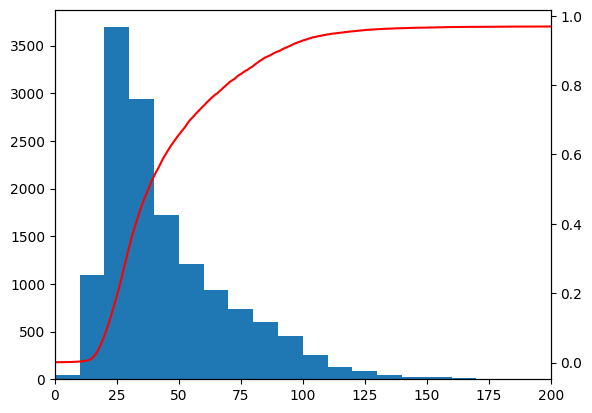

In [150]:
import matplotlib.pyplot as plt

data = pd.read_csv('/Users/rachelbrandt/egvinsulin/CleanedData/DCLP5_TDD_data.csv')
N = len(data)
cdfx = np.sort(data.TDD.values)
cdfy = np.linspace(1 / len(data.TDD.values), 1.0, len(data.TDD.values))
F2 = np.array(range(N))/float(N)
# plot the CDF
# plt.gca().set_xscale('symlog')
# plt.ylim([0,1])
fig, ax2 = plt.subplots()
ax2.hist(data.TDD,bins=np.arange(0,220,10))
ax2.set_xlim([0,200])
ax1 = ax2.twinx()
ax1.plot(cdfx, cdfy,color='r')
plt.show()

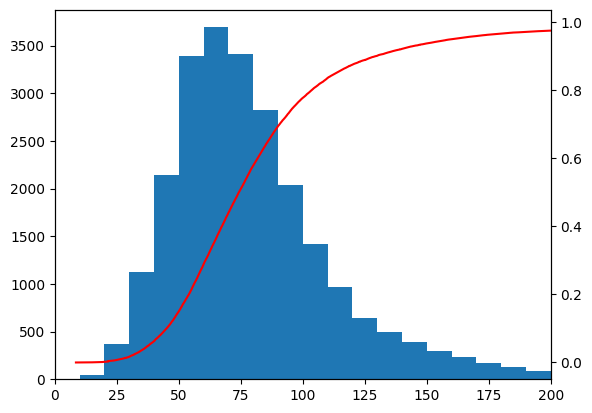

In [153]:
import matplotlib.pyplot as plt

data = pd.read_csv('/Users/rachelbrandt/egvinsulin/CleanedData/FLAIR_TDD_data.csv')
N = len(data)
cdfx = np.sort(data.TDD.values)
cdfy = np.linspace(1 / len(data.TDD.values), 1.0, len(data.TDD.values))
F2 = np.array(range(N))/float(N)
# plot the CDF
# plt.gca().set_xscale('symlog')
# plt.ylim([0,1])
fig, ax2 = plt.subplots()
ax2.hist(data.TDD,bins=np.arange(0,220,10))
ax2.set_xlim([0,200])
ax1 = ax2.twinx()
ax1.plot(cdfx, cdfy,color='r')
plt.show()

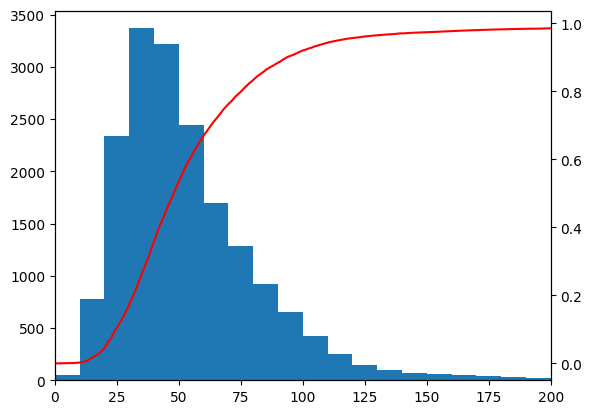

In [155]:
import matplotlib.pyplot as plt

data = pd.read_csv('/Users/rachelbrandt/egvinsulin/CleanedData/DCLP3_TDD_data.csv')
N = len(data)
cdfx = np.sort(data.TDD.values)
cdfy = np.linspace(1 / len(data.TDD.values), 1.0, len(data.TDD.values))
F2 = np.array(range(N))/float(N)
# plot the CDF
# plt.gca().set_xscale('symlog')
# plt.ylim([0,1])
fig, ax2 = plt.subplots()
ax2.hist(data.TDD,bins=np.arange(0,220,10))
ax2.set_xlim([0,200])
ax1 = ax2.twinx()
ax1.plot(cdfx, cdfy,color='r')
plt.show()

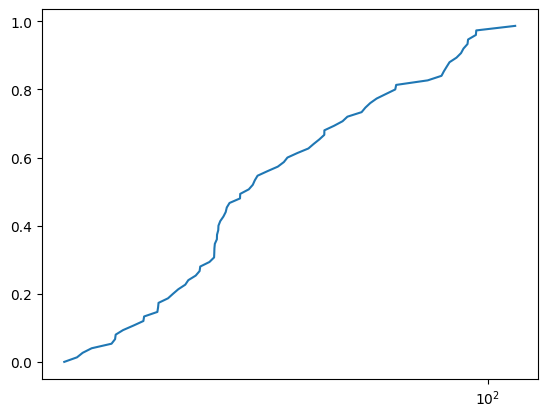

In [152]:
data = pd.read_csv('/Users/rachelbrandt/egvinsulin/CleanedData/DCLP5_TDD_data.csv')
data = data.dropna()
# data = data[data.TDD > 30]
geomean_TDD = pd.DataFrame(index=range(len(data.PtID.unique())), columns=['PtID','TDD'])
i = 0
for id in data.PtID.unique():
    data_sub = data[data.PtID == id]
    geomean_TDD.PtID[i] = id
    geomean_TDD.TDD[i] = data_sub.TDD.mean()
    i += 1

N = len(geomean_TDD)
cdfx = np.sort(geomean_TDD.TDD.values)
cdfy = np.linspace(1 / len(geomean_TDD.TDD.values), 1.0, len(geomean_TDD.TDD.values))
F2 = np.array(range(N))/float(N)
# plot the CDF
plt.gca().set_xscale('symlog')
# plt.ylim([0,1])

plt.plot(cdfx, F2)
plt.show()

<Axes: >

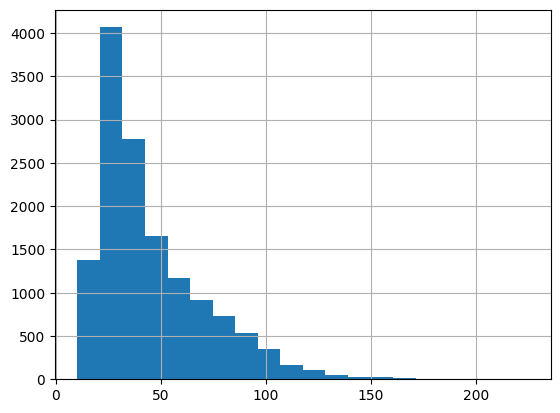

In [137]:
data.TDD.hist(bins=20)

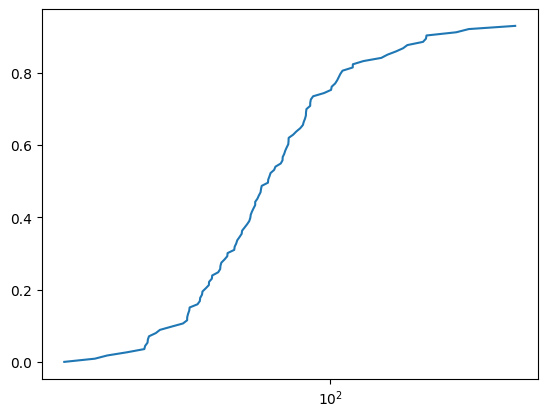

In [123]:
data = pd.read_csv('/Users/rachelbrandt/egvinsulin/CleanedData/FLAIR_TDD_data.csv')
data = data.dropna()
geomean_TDD = pd.DataFrame(index=range(len(data.PtID.unique())), columns=['PtID','TDD'])
i = 0
for id in data.PtID.unique():
    data_sub = data[data.PtID == id]
    geomean_TDD.PtID[i] = id
    geomean_TDD.TDD[i] = data_sub.TDD.mean()
    i += 1

N = len(geomean_TDD)
cdfx = np.sort(geomean_TDD.TDD.values)
cdfy = np.linspace(1 / len(geomean_TDD.TDD.values), 1.0, len(geomean_TDD.TDD.values))
F2 = np.array(range(N))/float(N)
# plot the CDF
plt.gca().set_xscale('symlog')
# plt.ylim([0,1])

plt.plot(cdfx, F2)
plt.show()

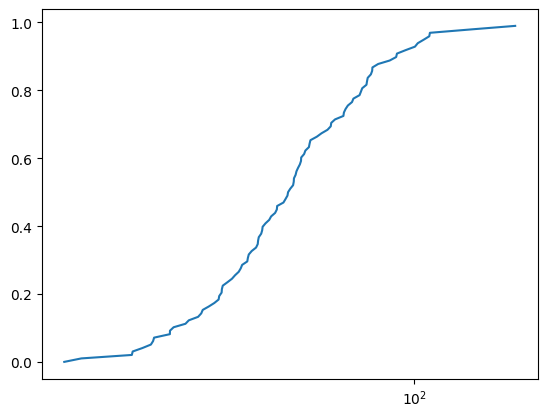

In [154]:
data = pd.read_csv('/Users/rachelbrandt/egvinsulin/CleanedData/DCLP3_TDD_data.csv')
data = data.dropna()
geomean_TDD = pd.DataFrame(index=range(len(data.PtID.unique())), columns=['PtID','TDD'])
i = 0
for id in data.PtID.unique():
    data_sub = data[data.PtID == id]
    geomean_TDD.PtID[i] = id
    geomean_TDD.TDD[i] = data_sub.TDD.mean()
    i += 1

N = len(geomean_TDD)
cdfx = np.sort(geomean_TDD.TDD.values)
cdfy = np.linspace(1 / len(geomean_TDD.TDD.values), 1.0, len(geomean_TDD.TDD.values))
F2 = np.array(range(N))/float(N)
# plot the CDF
plt.gca().set_xscale('symlog')
# plt.ylim([0,1])

plt.plot(cdfx, F2)
plt.show()

In [124]:
cdfy

array([0.00884956, 0.01769912, 0.02654867, 0.03539823, 0.04424779,
       0.05309735, 0.0619469 , 0.07079646, 0.07964602, 0.08849558,
       0.09734513, 0.10619469, 0.11504425, 0.12389381, 0.13274336,
       0.14159292, 0.15044248, 0.15929204, 0.16814159, 0.17699115,
       0.18584071, 0.19469027, 0.20353982, 0.21238938, 0.22123894,
       0.2300885 , 0.23893805, 0.24778761, 0.25663717, 0.26548673,
       0.27433628, 0.28318584, 0.2920354 , 0.30088496, 0.30973451,
       0.31858407, 0.32743363, 0.33628319, 0.34513274, 0.3539823 ,
       0.36283186, 0.37168142, 0.38053097, 0.38938053, 0.39823009,
       0.40707965, 0.4159292 , 0.42477876, 0.43362832, 0.44247788,
       0.45132743, 0.46017699, 0.46902655, 0.47787611, 0.48672566,
       0.49557522, 0.50442478, 0.51327434, 0.52212389, 0.53097345,
       0.53982301, 0.54867257, 0.55752212, 0.56637168, 0.57522124,
       0.5840708 , 0.59292035, 0.60176991, 0.61061947, 0.61946903,
       0.62831858, 0.63716814, 0.6460177 , 0.65486726, 0.66371

In [125]:
F2

array([0.        , 0.00884956, 0.01769912, 0.02654867, 0.03539823,
       0.04424779, 0.05309735, 0.0619469 , 0.07079646, 0.07964602,
       0.08849558, 0.09734513, 0.10619469, 0.11504425, 0.12389381,
       0.13274336, 0.14159292, 0.15044248, 0.15929204, 0.16814159,
       0.17699115, 0.18584071, 0.19469027, 0.20353982, 0.21238938,
       0.22123894, 0.2300885 , 0.23893805, 0.24778761, 0.25663717,
       0.26548673, 0.27433628, 0.28318584, 0.2920354 , 0.30088496,
       0.30973451, 0.31858407, 0.32743363, 0.33628319, 0.34513274,
       0.3539823 , 0.36283186, 0.37168142, 0.38053097, 0.38938053,
       0.39823009, 0.40707965, 0.4159292 , 0.42477876, 0.43362832,
       0.44247788, 0.45132743, 0.46017699, 0.46902655, 0.47787611,
       0.48672566, 0.49557522, 0.50442478, 0.51327434, 0.52212389,
       0.53097345, 0.53982301, 0.54867257, 0.55752212, 0.56637168,
       0.57522124, 0.5840708 , 0.59292035, 0.60176991, 0.61061947,
       0.61946903, 0.62831858, 0.63716814, 0.6460177 , 0.65486